In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN


In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

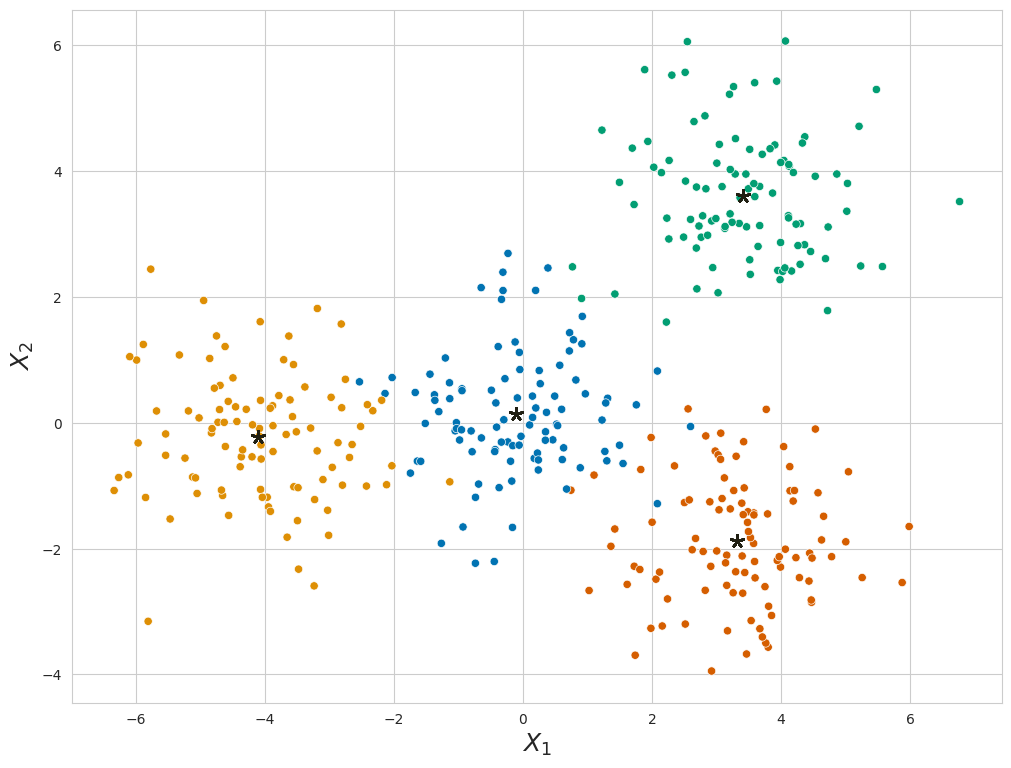

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):

            print(f"Итерация {_+1}/{self.max_iter}")  # Вывод текущей итерации
            
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """ 
        
        dists = np.hstack([self._calculate_distance(X, centroid) for centroid in self.centroids])
        cluster_labels = np.argmin(dists, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        dist = np.sqrt(((X - centroid) ** 2).sum(axis=1))
        
        return dist.reshape(-1, 1) 
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

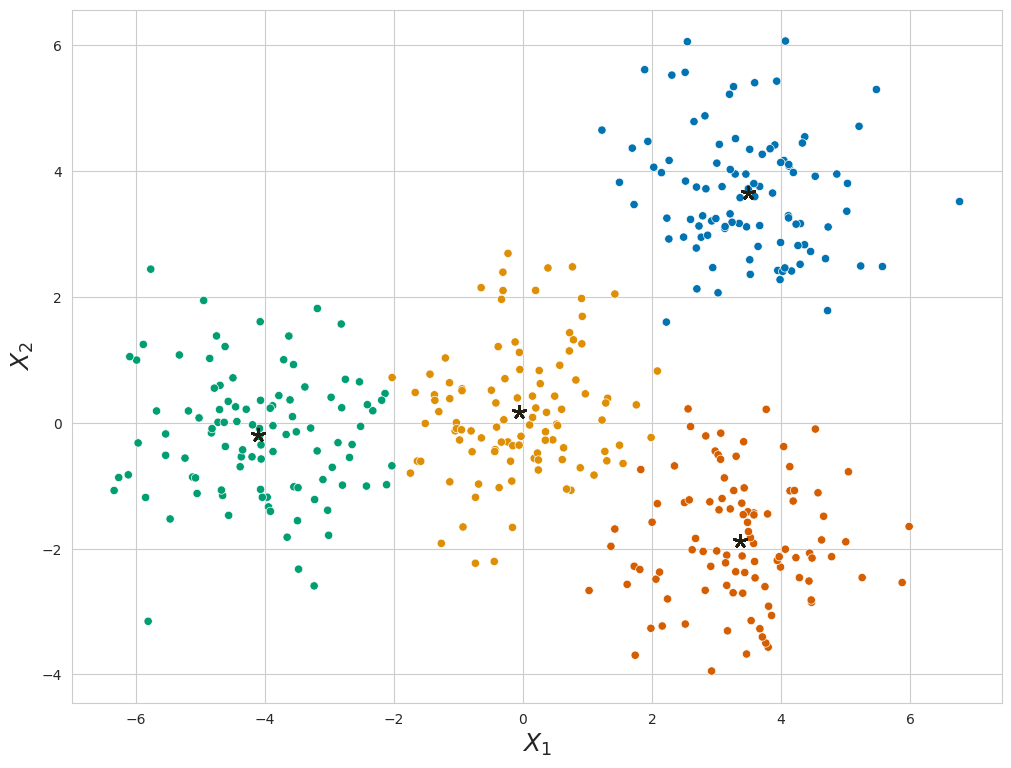

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
my_kmeans_random = MyKMeans(4, init="random", max_iter=50, visualize=True)
my_kmeans_random.fit(X)

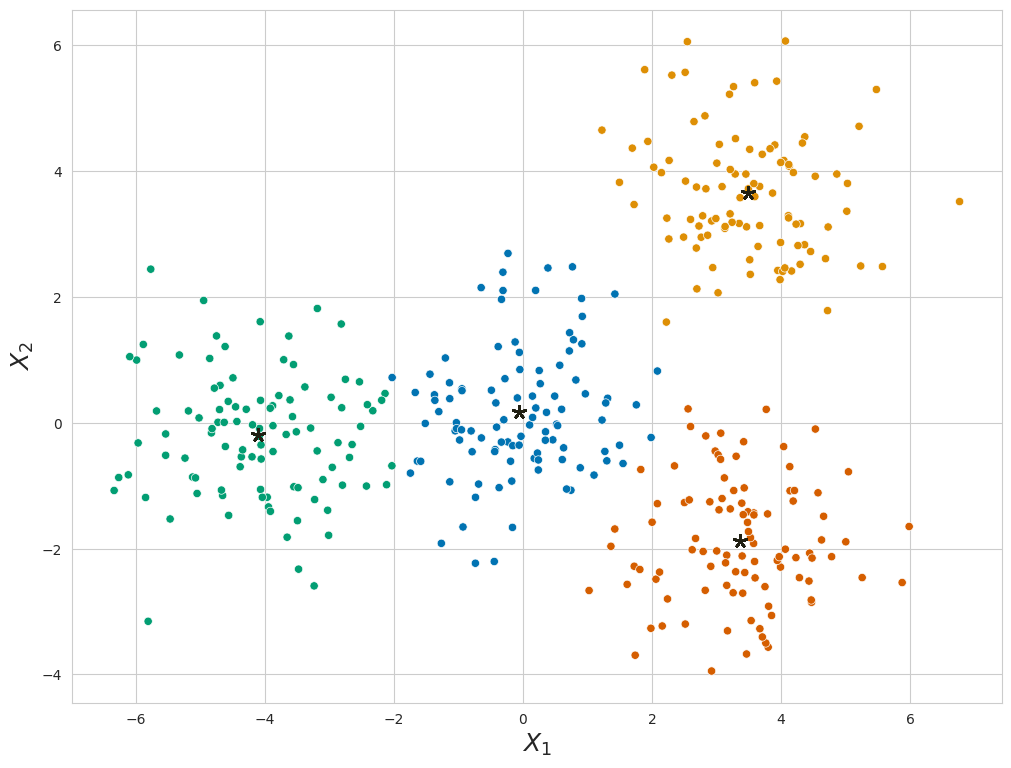

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:
my_kmeans_sample= MyKMeans(4, init="sample", max_iter=50, visualize=True)
my_kmeans_sample.fit(X)


Конкретно при 50 иттерациях алгоритм предсказывет кластеры одинаково и независимо от способа инициализации центроида,
однако по идее метод инициализации "sample" (выбор случайных точек из данных в качестве начальных центроидов) должен работать лучше, чем "random" (выбор из нормального распределения), потому что в этом случае кластеризация начинается с более реалистичных позиций, которые уже точно есть в данных.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [9]:
data = load_digits()
X, y = data.data, data.target

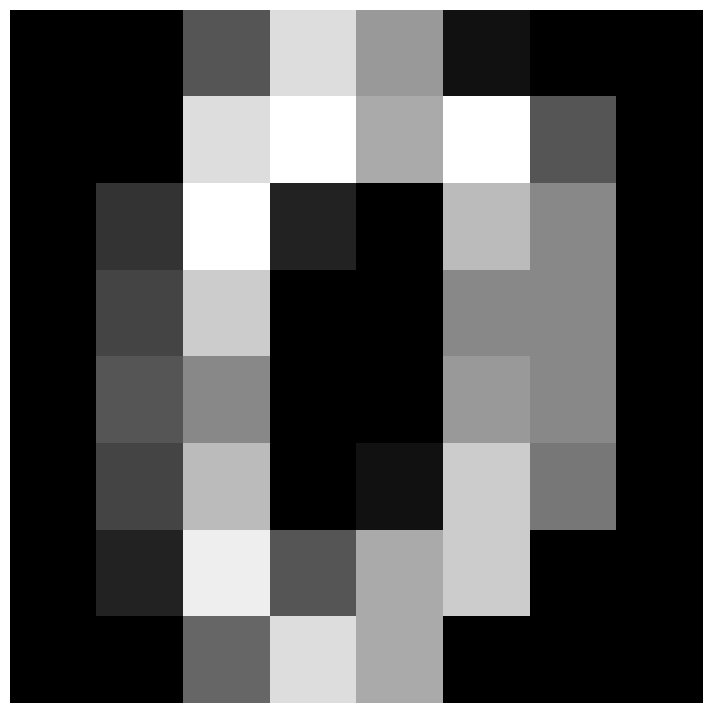

In [10]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [11]:
def algorithm_selection(X, y, distances, algorithms, metrics):
    """
    Выполняет иерархическую кластеризацию данных с использованием различных метрик расстояния и алгоритмов связи.
    Для каждой комбинации метрики расстояния и алгоритма связи вычисляет заданные метрики качества кластеризации.
        :param X: наши данные (n_samples, n_features)
        :param y: массив истинных меток классов размерностью (n_samples,), используется для вычисления метрик качества.
        :param distances: список возможных метрик расстояния (допустимые значения "euclidean", "l1", "cosine", "precomputed")
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации (допустимые значения 'homogeneity', 'completeness', 'v_measure', 'silhouette')
    :return compare_dataframe: таблица с метриками кластеризации 
    """
    results = []
    for distance in distances:
        for algorithm in algorithms:
            if distance == 'precomputed':
                # Вычисляем матрицу попарных расстояний для 'minkowski' с p=3
                X_precomputed = squareform(pdist(X, metric='minkowski', p=3))
                X_used = X_precomputed
            else:
                X_used = X
        
        for algorithm in algorithms:
            # Создание модели кластеризации
            if distance == 'precomputed':
                    clustering = AgglomerativeClustering(n_clusters=len(np.unique(y)), metric='precomputed', linkage=algorithm)
            else:
                clustering = AgglomerativeClustering(n_clusters=len(np.unique(y)), metric=distance, linkage=algorithm)
            
            # Обучение модели
            # Для 'precomputed' используем X_precomputed, иначе - исходные данные
            y_pred = clustering.fit_predict(X_used if distance == 'precomputed' else X)
            
            # Вычисление метрик качества
            scores = {}
            if distance != 'precomputed':
                scores['silhouette'] = silhouette_score(X, y_pred, metric=distance)
            else:
                # Silhouette score не может быть вычислен напрямую для 'precomputed'
                scores['silhouette'] = silhouette_score(X, y_pred, metric='euclidean')
            
            scores.update({
                'homogeneity': homogeneity_score(y, y_pred),
                'completeness': completeness_score(y, y_pred),
                'v_measure': v_measure_score(y, y_pred),
            })
            
            # Сохранение результатов
            result = {
                'distance': distance,
                'linkage': algorithm,
            }
            result.update(scores)
            results.append(result)
    
    # Преобразование результатов в табличку
    compare_dataframe = pd.DataFrame(results)
    return compare_dataframe


In [12]:
distance_metrics = ['euclidean', 'l1', 'cosine', 'precomputed']
algs = ['average', 'single', 'complete']
quality_metrics = ['homogeneity', 'completeness', 'v_measure', 'silhouette']
results_df = algorithm_selection(X, y, distance_metrics, algs, quality_metrics)
results_df

,distance,linkage,silhouette,homogeneity,completeness,v_measure
0,euclidean,average,0.146625,0.655393,0.782342,0.713263
1,euclidean,single,-0.133621,0.005056,0.273755,0.009929
2,euclidean,complete,0.119271,0.590549,0.637772,0.613253
3,l1,average,0.105238,0.566751,0.778942,0.656117
4,l1,single,-0.203816,0.005102,0.276237,0.010019
5,l1,complete,0.160617,0.646372,0.686109,0.665648
6,cosine,average,0.218229,0.648268,0.808762,0.719676
7,cosine,single,-0.281789,0.005050,0.273389,0.009916
8,cosine,complete,0.144179,0.528727,0.577415,0.551999
9,precomputed,average,0.148230,0.709955,0.819908,0.760980


Лушче всего сработал вариант с precomputed расстоянием (расстояние Минковского) с average linkage, так как этот вариант обеспечивает наилучшее сочетание однородности, полноты и V-measure, что указывает на высокое качество кластеризации. 

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [26]:
fc_data = pd.read_csv("../data/flow_c_data.csv", index_col=0)

##### YOUR TURN TO CODE:

In [27]:
fc_data.shape

(10000, 9)

Всего 10000 наблюдений (клеток) и 9 признаков

In [28]:
fc_data.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.962458,0.165415,1.791579,3.280391,5.169845,1.097182,0.412223,1.219683,0.569898
std,0.500012,0.190773,2.027281,2.112079,0.518247,1.375876,1.176967,2.285305,1.502445
min,0.144786,0.021657,-7.634172,-2.517639,-8.329666,-8.833883,-12.358701,-9.640775,-11.085437
25%,0.798804,0.105550,0.275056,1.401943,4.922227,0.389746,-0.195978,-0.146948,-0.498781
50%,0.908574,0.130543,1.194313,4.373660,5.234119,0.672853,0.053267,0.244121,0.272297
75%,1.052034,0.162536,3.696976,4.842212,5.481218,1.065076,0.378576,0.908374,1.220576
max,42.954485,15.460997,12.946668,13.844391,13.710922,6.294236,6.461899,7.208721,6.840864


Я никогда не делалала проточную цитометрию, но если в столбцах начиная с HLA-DR и до конца - интенсивность флуоресцентного сигнала, то флуоресценция не бывает отрицательной и по идее все значения меньше 0 - выбросы. Поскольку не было сказано, как поступать с предполагаемыми выбросами, я их трогать не буду.

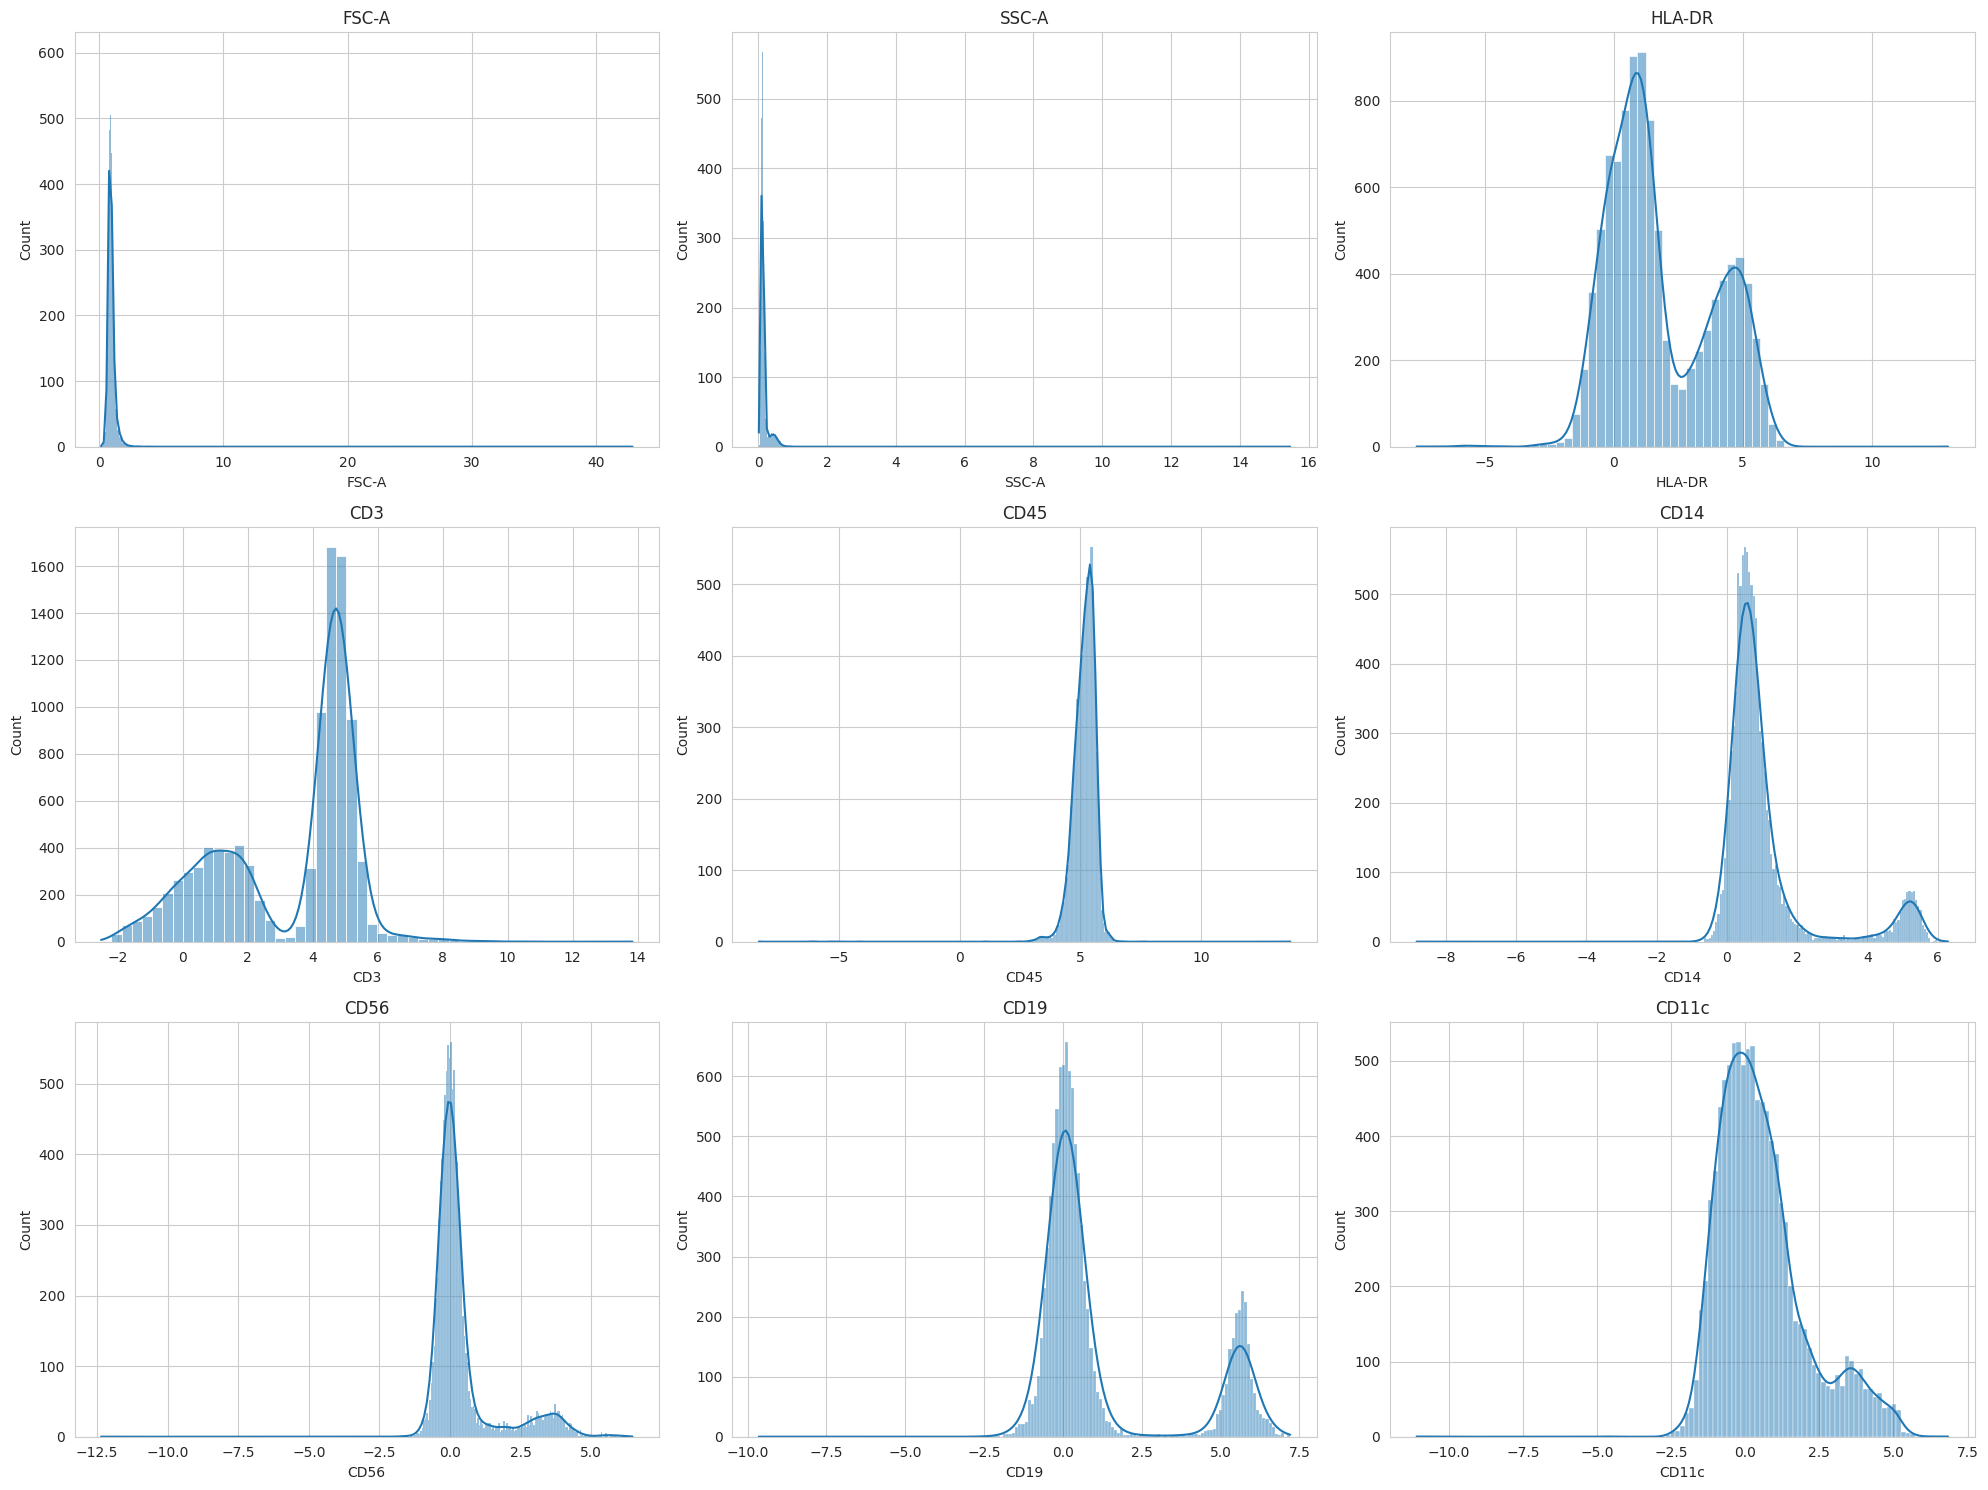

In [29]:
# Построение гистограмм для каждого признака
plt.figure(figsize=(20, 15))
for i, column in enumerate(fc_data.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(fc_data[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()


#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [30]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

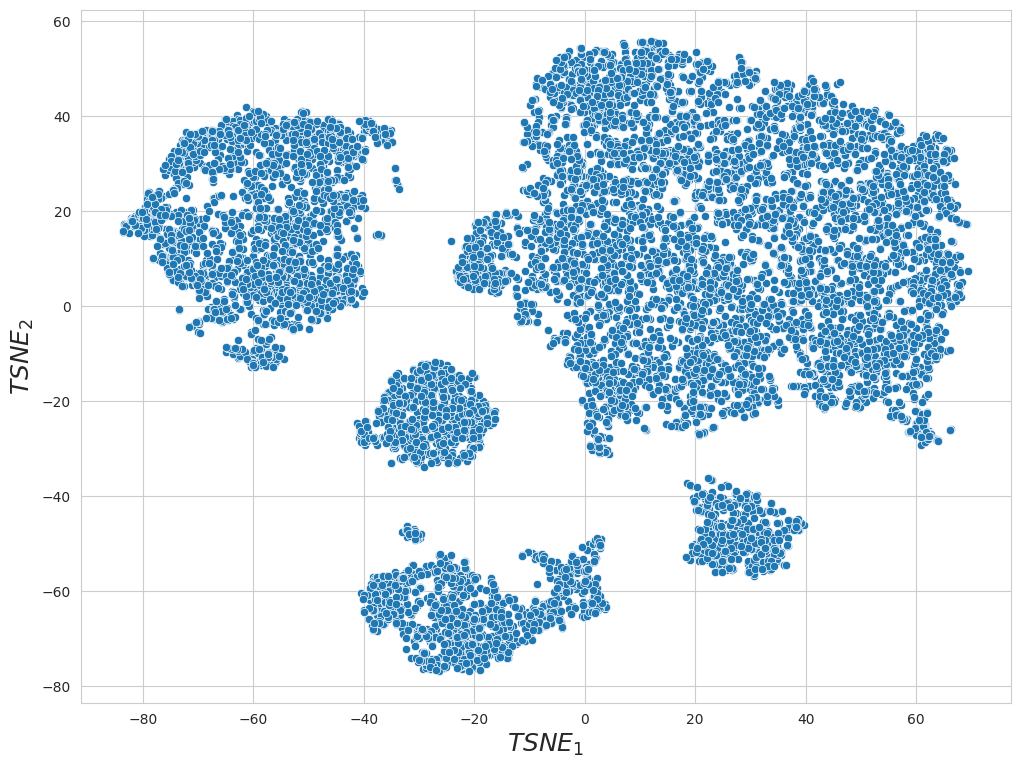

In [31]:
tsne_res = plot_tsne(fc_data)

А так будет выглядеть, если выкинуть отрицательную флуоресценцию. Правда наблюдений останется всего 1492.

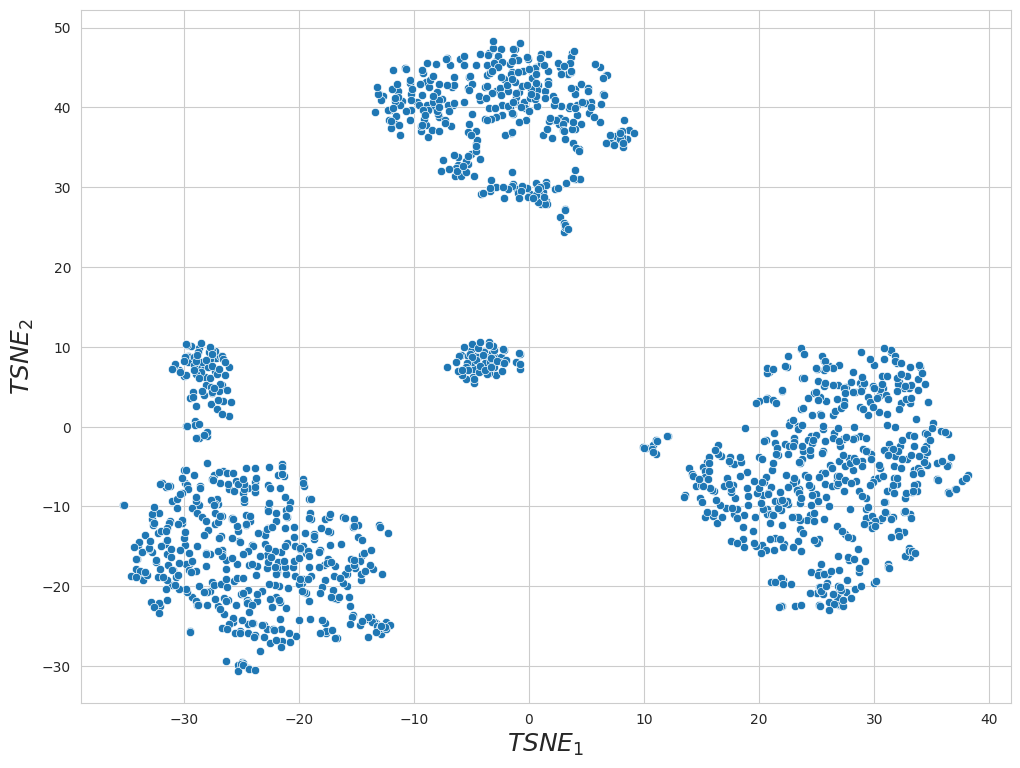

In [35]:
filtered_data = fc_data[(fc_data > 0).all(axis=1)]
tsne_res_filtered = plot_tsne(filtered_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [36]:
#Случай, когда используем все данные
# 1. K-Means
kmeans_5 = KMeans(n_clusters=5, random_state=SEED)
kmeans_labels_5 = kmeans_5.fit_predict(fc_data)

# 2. Hierarchical Clustering
hierarchical_5 = AgglomerativeClustering(n_clusters=5)
hierarchical_labels_5 = hierarchical_5.fit_predict(fc_data)

# 3. DBSCAN
dbscan_5 = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels_5 = dbscan_5.fit_predict(fc_data)


# Вычисление silhouette score для каждого метода
silhouette_kmeans = silhouette_score(fc_data, kmeans_labels_5)
silhouette_hierarchical = silhouette_score(fc_data, hierarchical_labels_5)
silhouette_dbscan = silhouette_score(fc_data, dbscan_labels_5) if len(set(dbscan_labels_5)) > 1 else -1

# Вывод результатов
silhouette_scores = {
    "K-Means": silhouette_kmeans,
    "Hierarchical": silhouette_hierarchical,
    "DBSCAN": silhouette_dbscan
}

silhouette_scores

{'K-Means': 0.5286460957224244,
 'Hierarchical': 0.46234099644262266,
 'DBSCAN': -0.47316608825022294}

В случае, если кластеризовать все 10000 клеток, исходя из показателя silhouette_score, самой удачной моделью оказалась с использованием K-Means. Поэтому нарисуем график t-SNE для него. 

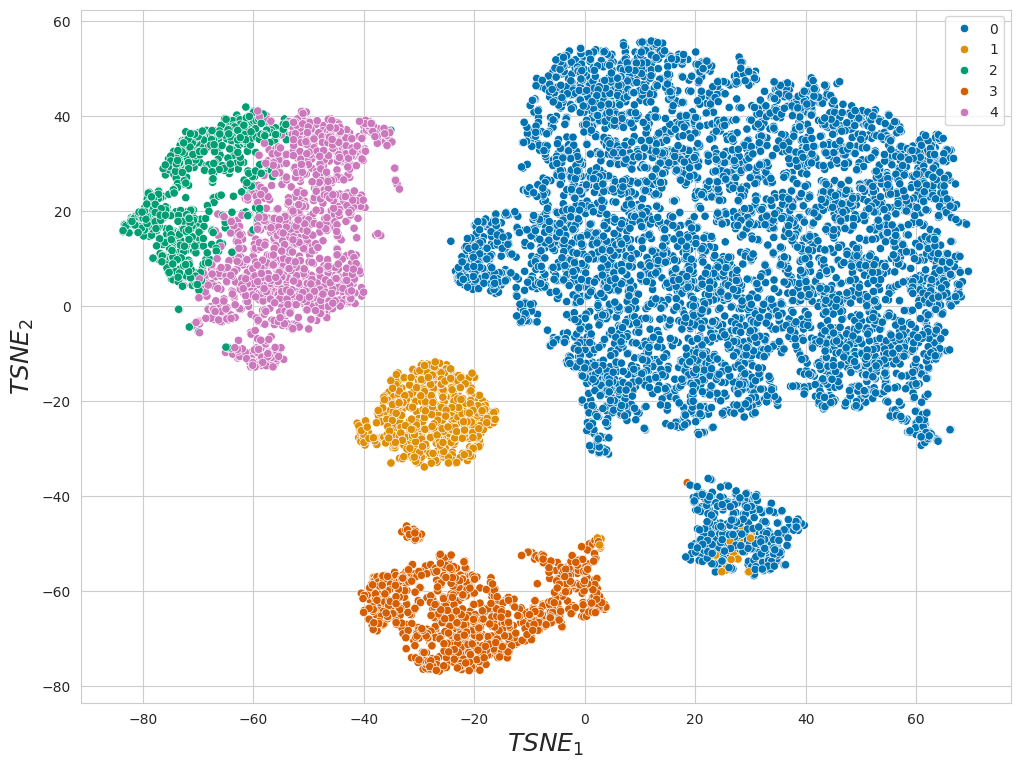

In [37]:
res = plot_tsne(fc_data, color = kmeans_labels_5)

В предыдущем случае я выбрала число кластеров = 5. И у меня k-means верхний левый кластер, который визуально воспринимается единым, разделил на 2 (зеленые и розовые точки). Это не очень хорошо, попробую сделать число кластеров равное 4.

In [38]:
kmeans_4 = KMeans(n_clusters=4, random_state=SEED)
kmeans_4_labels = kmeans_4.fit_predict(fc_data)
silhouette_kmeans_4 = silhouette_score(fc_data, kmeans_4_labels)
silhouette_kmeans_4


0.6101329228000268

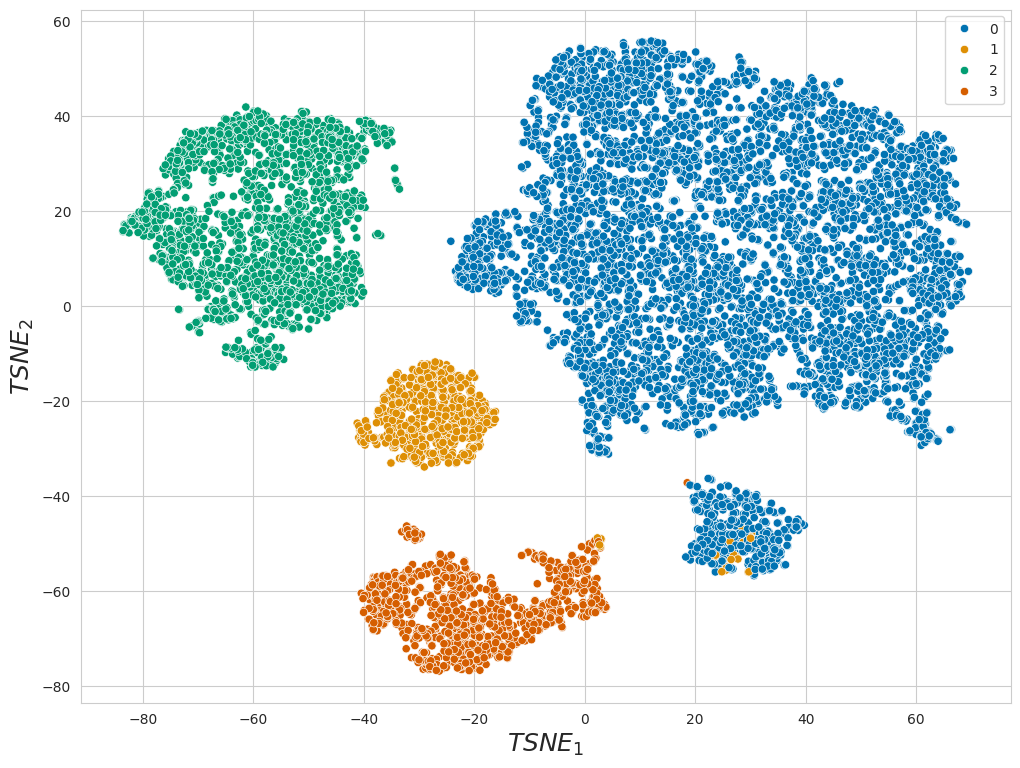

In [39]:
res = plot_tsne(fc_data, color = kmeans_4_labels)

**Отлично**

Если k-means дать число кластеров = 4, то и silhouette_score будет повыше, и верхний левый кластер перестал в один сливаться, что тоже хорошо.

Ну и забавы ради можно попробовать кластеризовать данные без отрицательной флуоресценции:

In [40]:
#Случай, когда используем отфильтрованные данные
# 1. K-Means
kmeans = KMeans(n_clusters=4, random_state=SEED)
kmeans_labels = kmeans.fit_predict(filtered_data)

# 2. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_labels = hierarchical.fit_predict(filtered_data)

# 3. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=4)
dbscan_labels = dbscan.fit_predict(filtered_data)


# Вычисление silhouette score для каждого метода
silhouette_kmeans = silhouette_score(filtered_data, kmeans_labels)
silhouette_hierarchical = silhouette_score(filtered_data, hierarchical_labels)
silhouette_dbscan = silhouette_score(filtered_data, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Вывод результатов
silhouette_scores = {
    "K-Means": silhouette_kmeans,
    "Hierarchical": silhouette_hierarchical,
    "DBSCAN": silhouette_dbscan
}

silhouette_scores

{'K-Means': 0.6333672163176438,
 'Hierarchical': 0.6382157575347258,
 'DBSCAN': -0.5484610923878639}

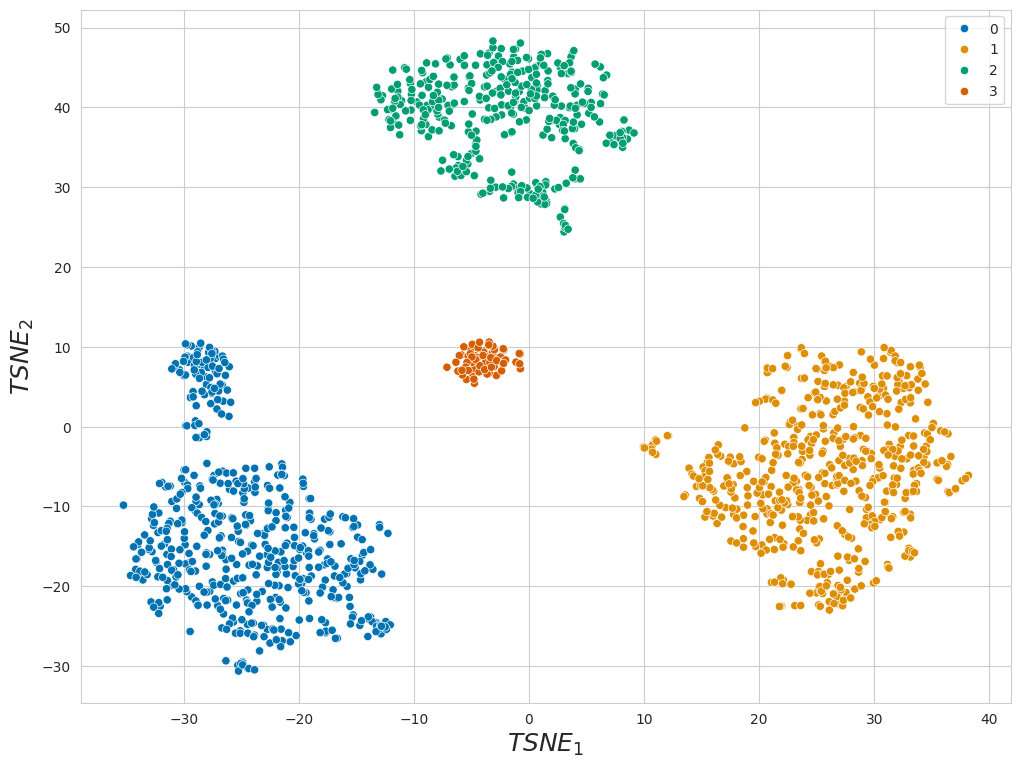

In [41]:
res = plot_tsne(filtered_data, color = hierarchical_labels)

Иерархическая кластеризация для случая, когда число кластеров = 4 и без отрицательных значений флуоресценции справилась идеально. Насколько это соотвествует биологической реальности я, если честно, не знаю.

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Да, там, где все 10 000 клеток и используется k-means, в правой половине два кластера (один большой и один маленький) покрашены оба в синий цвет, хотя визуально они прям разные.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

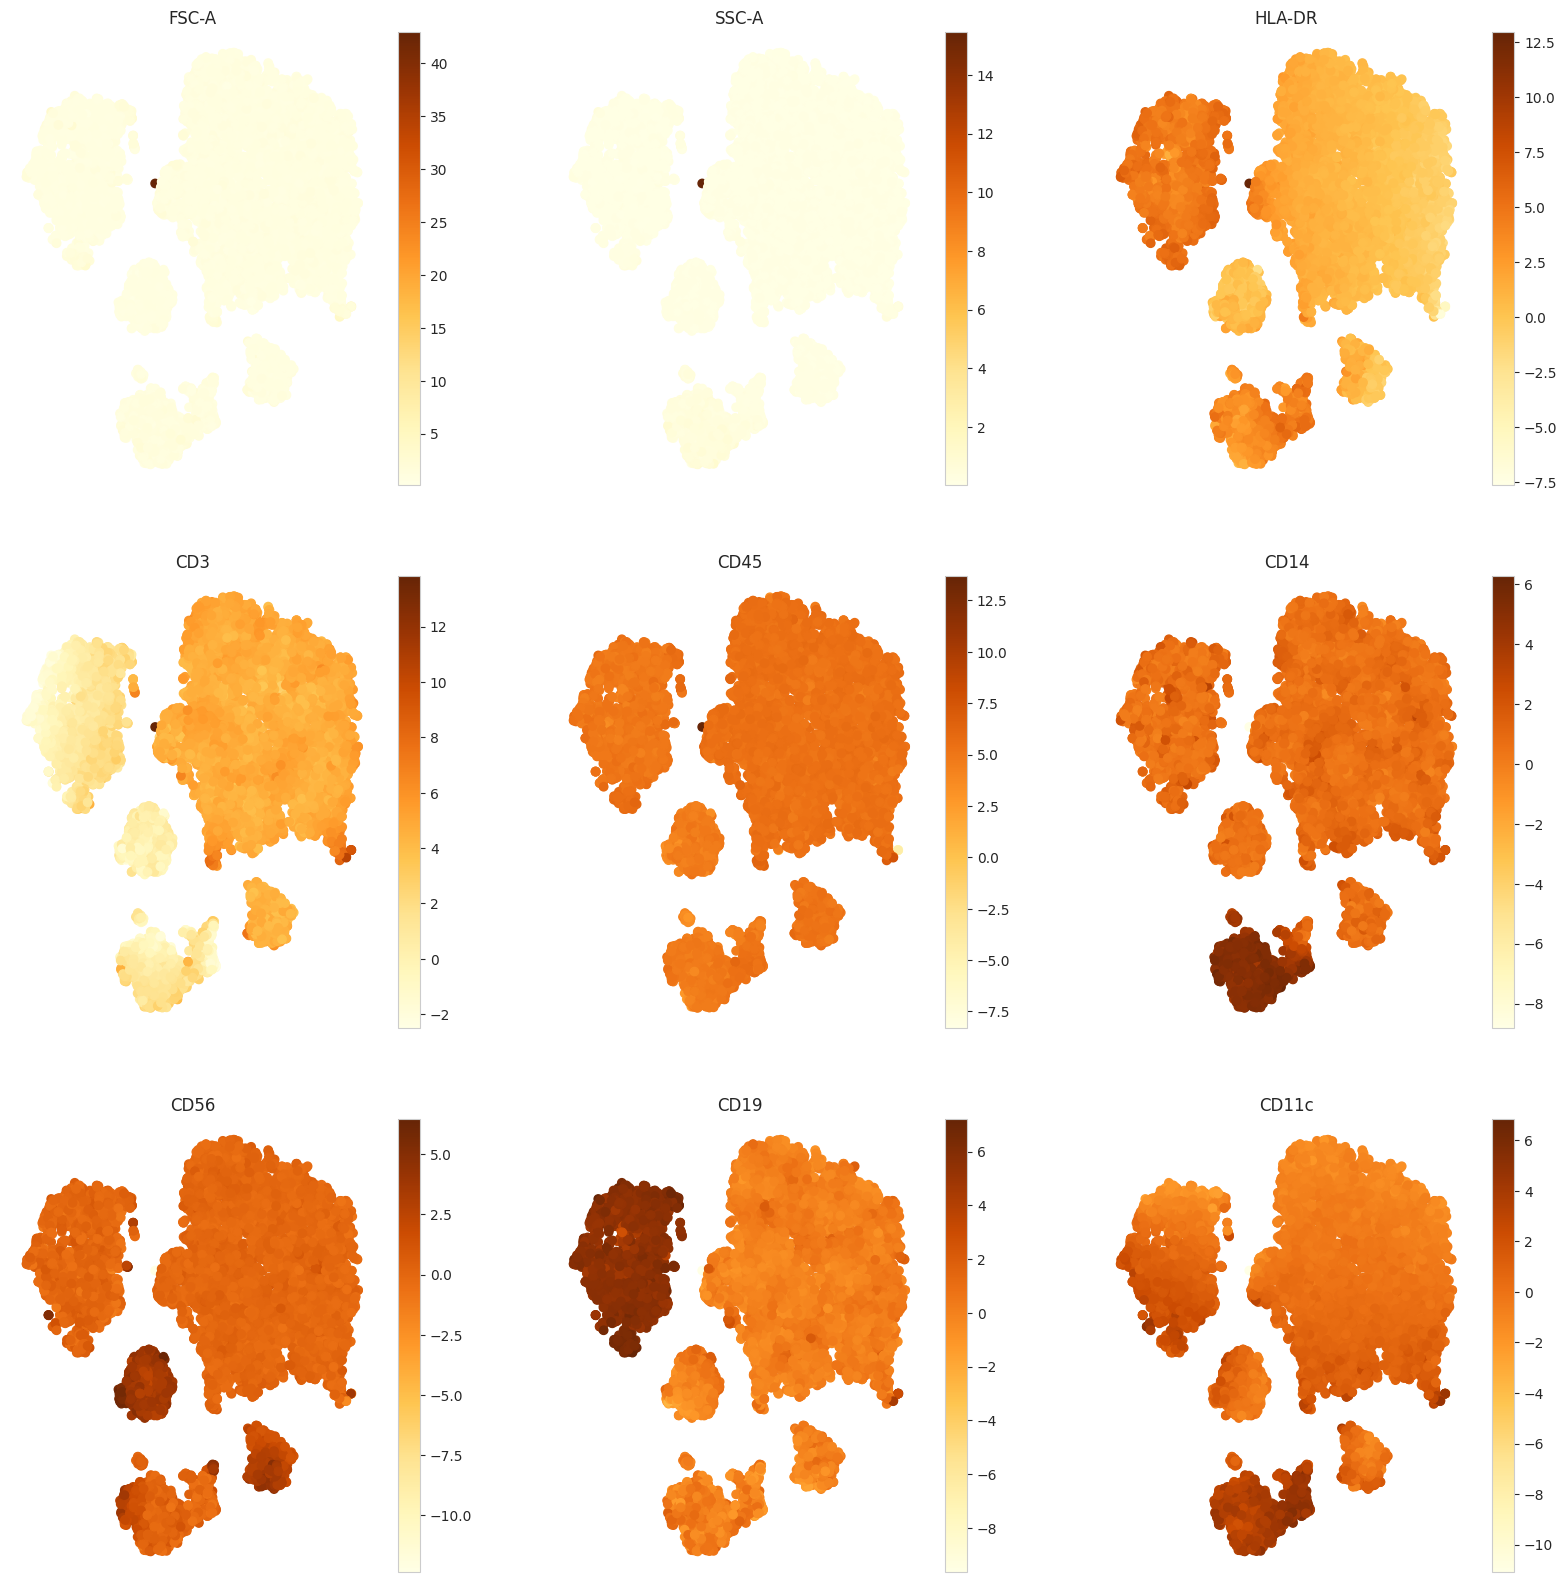

In [42]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [43]:
cell_type_cluster_map = {0: "T_cells", 
                         1: "Other cells", 
                         2: "CB_cells", 
                         3: "Monocytes"}

In [44]:
labeled_fc_data = fc_data.assign(Population=kmeans_4.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)


Посчитайте, как распределены типы клеток:

In [45]:
labeled_fc_data["Population"].value_counts(normalize=True)

Population
T_cells        0.6201
CB_cells       0.2035
Monocytes      0.1091
Other cells    0.0673
Name: proportion, dtype: float64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [46]:
labeled_fc_data.to_csv('../data/labeled_fc_data.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Больше всего я люблю бывать на природе.
Одно из мест, которое мне очень-очень нравится (не только из-за названия, как можно будет подумать) - заповедник в маленьком городке Hřensko (Грженско). Там много гектаров очень классного леса и ландшафта вообще, тихо, спокойно, немноголюдно и красиво. Еще там есть необычная достаточно высокая природная арка из песчаника (см. фото), глядя на которую можно долго сидеть и залипать.

Я была там осенью 2018. С удовольствем съездила бы этой весной, но вряд ли получится.
![photo1](../data/Hrensko1.jpg)
![photo2](../data/Hrensko3.jpg)


### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**